In [ ]:
import time 
import itertools 
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import mujoco
import distutils.util
import os
import subprocess


: 

""

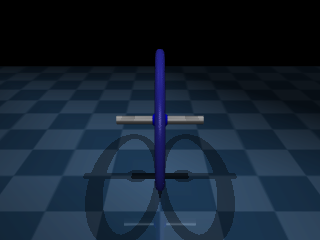

In [3]:
#XML

np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Defining the wheel here...
xml = """
<mujoco>
  <extension>
    <plugin plugin="mujoco.sdf.torus">
      <instance name="torus">
        <config key="radius1" value="1.5"/>
        <config key="radius2" value="0.10"/>
      </instance>
    </plugin>
  </extension>

  <asset>
    <mesh name="torus">
      <plugin instance="torus"/>
    </mesh>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <option sdf_iterations="10" sdf_initpoints="40"/>

  <default>
    <geom solref="0.01 1" solimp=".95 .99 .0001" friction="40"/>
  </default>

  <worldbody>
  <camera name="my_camera" pos="-5 -5 10" euler="30 -20 10"/>

    <geom size="10 10 10" type="plane" material="grid"/>
    <body name="wheel and axle" pos="0 0 1.6">
      <freejoint/>
      <geom type="sdf" mesh="torus" rgba=".2 .2 .8 1" euler="10 90 90" mass = "100" >
          <plugin instance="torus"/>
      </geom>
      <geom name= "cylinder" type= "cylinder" size = "0.1 1" euler= "0 90 0" mass = "0"/>
      <body name="sphere" pos="0 0 0">
          <joint name="slider1" type="slide" axis = "1 0 0" />
          <geom type="sphere" size="0.2" rgba="0 0 1 1" mass = "0.01"/>
      </body>

     
      
      <camera name="track" pos="0 -6 3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
    

        
    
    <light name="left" pos="-2 0 7" cutoff="80"/>
    <light name="right" pos="2 0 7" cutoff="80"/>
    
  </worldbody>
  <actuator>
    <motor name="my_motor" joint="slider1"/>
  </actuator>

  <keyframe>
    <key name="spinning" qpos="0 0 1.6 0 0 0 0  0" qvel=" 0 0 0 0 0 0 0  " />  #See read.me for d.o.f. z start at 1.6 to be on the ground. Last d.o.f for ball
  </keyframe>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml) # this makes a model out of the xml such that we can use it. 

data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
# media.show_image(renderer.render())

mujoco.mj_forward(model, data)
renderer.update_scene(data, "track")

media.show_image(renderer.render())

Render the video

In [15]:
#Specify location of ffmpeg
import os

# Specify the full path to ffmpeg
ffmpeg_path = "/opt/homebrew/Cellar/ffmpeg/7.0.1"

# Update the PATH environment variable to include the directory containing ffmpeg
os.environ['PATH'] += os.pathsep + os.path.dirname(ffmpeg_path)


In [5]:
def render(xml, duration, framerate, camera, slow_motion: int =1, control: np.ndarray = None ):
    model = mujoco.MjModel.from_xml_string(xml) # this makes a model out of the xml such that we can use it. 

    data = mujoco.MjData(model)

    # Make renderer, render and show the pixels
    renderer = mujoco.Renderer(model)
    # media.show_image(renderer.render())

    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    
    #media.show_image(renderer.render())
    
    # Simulate and display video.
    frames = []
    mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
    i = 0
    while data.time < duration:

        #need to add a control here
        if control is not None:
            data.ctrl = control[i]
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate * slow_motion:
            renderer.update_scene(data, camera)
            pixels = renderer.render()
            frames.append(pixels)
        i +=1
    media.show_video(frames, fps=framerate)
    print(i-1)

In [16]:
render(xml,10, 20, "track", slow_motion= 1)

RuntimeError: Program 'ffmpeg' is not found; perhaps install ffmpeg using 'apt install ffmpeg'.

Match control to that in Daoyuan's paper.
there are 500 "steps" in each second of real time

1500


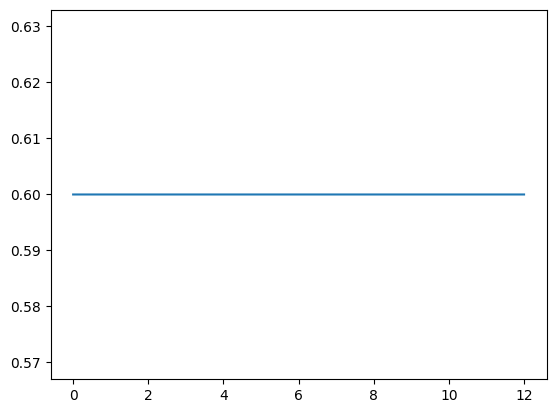

In [143]:
#What is the mass of the wheel?
# remember we are putting in the force, not the acceleration, need to divide by m_sphere
# m = 0.2
# phidot = -2

# freq_m = np.sqrt((2/(3+2*m)) * (-1 +4*phidot**2 - m +2*m*phidot**2)) # approx 3.1 in paper

# freq = 5
# c0 = 0.2
# cddotnot = c0*freq**2 

# converted_freq = freq / 500 #steps per second

duration = 3
step_values = np.linspace(0, duration*500, duration*500 +1)

# control_values = -cddotnot * np.sin(converted_freq * step_values)

control_values = step_values * 0 +0.6
plt.plot(step_values*4 /500, control_values)

render(xml, duration, 20, "track", slow_motion= 4,control = control_values )

Contact forces

In [10]:
n_frames = 400
height = 240
width = 320
frames = []
renderer = mujoco.Renderer(model, height, width)

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3



# simulate and render
mujoco.mj_resetDataKeyframe(model, data, 0)
for i in range(n_frames):
  while data.time < i/30: #1/4x real time by dividing by 120
    mujoco.mj_step(model, data)
  renderer.update_scene(data, "track", options)
  frame = renderer.render()
  frames.append(frame)

# show video
media.show_video(frames, fps=30)

Trying to get the contact point. Almost there but need to finish this up. This first section of code is to smooth out the signal using a low pass filter.

In [9]:
n_steps = 600
mujoco.mj_resetDataKeyframe(model, data, 0) #reset to OG frame
contacts = [] #needs to be list because of irregularly shaped data
for i in range(n_steps):
    mujoco.mj_step(model, data) #step forward
    try:
        median_contact = np.median(data.contact.pos, axis = 0) 
    except ValueError: 
        median_contact = [np.nan,np.nan,np.nan]
        
    contacts.append(median_contact)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


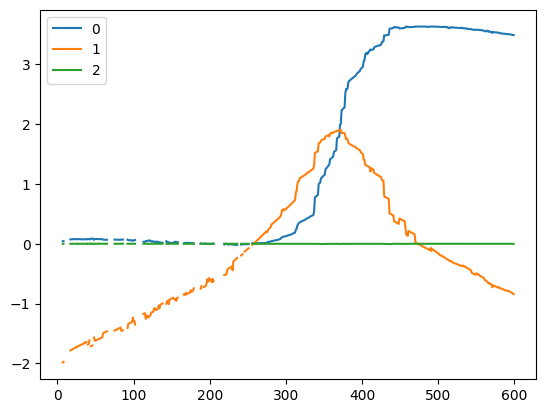

In [102]:
array = np.array(contacts)
for i in range(3):
    plt.plot(array[:,i], label = f"{i}")
plt.legend()

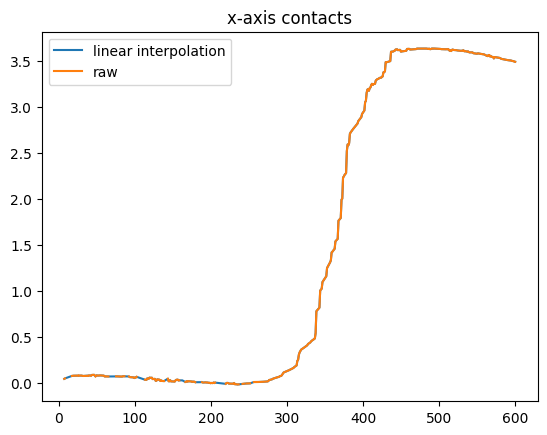

In [110]:
#Interpolate
from scipy.interpolate import interp1d

# Generate x-axis (not in mujoco space but x-axis on the plot)
x = np.linspace(0, np.shape(array)[0],np.shape(array)[0])

#Example with x values
# Interpolate NaN values
x_axis_dyn = array[:,0]
mask = np.isnan(x_axis_dyn)

if len(x) != len(x_axis_dyn):
    print("length error")

x_interp = x[~mask]
y_interp = x_axis_dyn[~mask]

f_interp = interp1d(x_interp, y_interp, kind='linear', bounds_error= False)
y_interpolated = f_interp(x)


plt.plot(x, y_interpolated, label = "linear interpolation")
plt.plot(x, array[:,0], label = "raw")
plt.title("x-axis contacts")
plt.legend()

In [104]:
#for some reason there are still a couple nan values at the beginning and at the very end. just remove them for now
mask = np.isnan(y_interpolated)
y_interpolated = y_interpolated[~mask]

Text(0.5, 1.0, 'FFT of x axis')

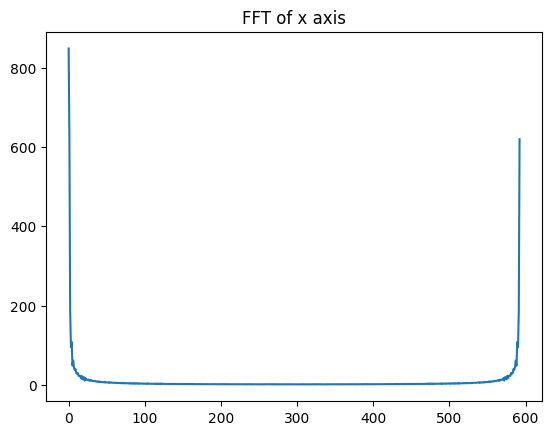

In [105]:
#fft
fft = np.fft.fft(y_interpolated)
plt.plot(np.abs(fft))
plt.title("FFT of x axis")

In [95]:
def low_pass_filter(adata: np.ndarray, bandlimit: int = 10000, sampling_rate: int = 44100) -> np.ndarray:
    # translate bandlimit from Hz to dataindex according to sampling rate and data size
    bandlimit_index = int(bandlimit * adata.size / sampling_rate)

    bandlimit_index = 500 #hardwriting it for test
    
    fsig = np.fft.fft(adata)
    
    for i in range(bandlimit_index + 1, len(fsig) - bandlimit_index ):
        fsig[i] = 0
        
    adata_filtered = np.fft.ifft(fsig)

    return np.real(adata_filtered)

In [106]:
filtered_array = low_pass_filter(y_interpolated)

Text(0.5, 1.0, 'Low-pass-filtered x-axis')

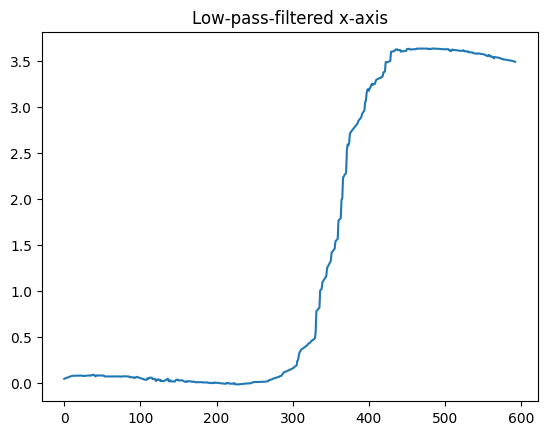

In [111]:
plt.plot(filtered_array)
plt.title("Low-pass-filtered x-axis")

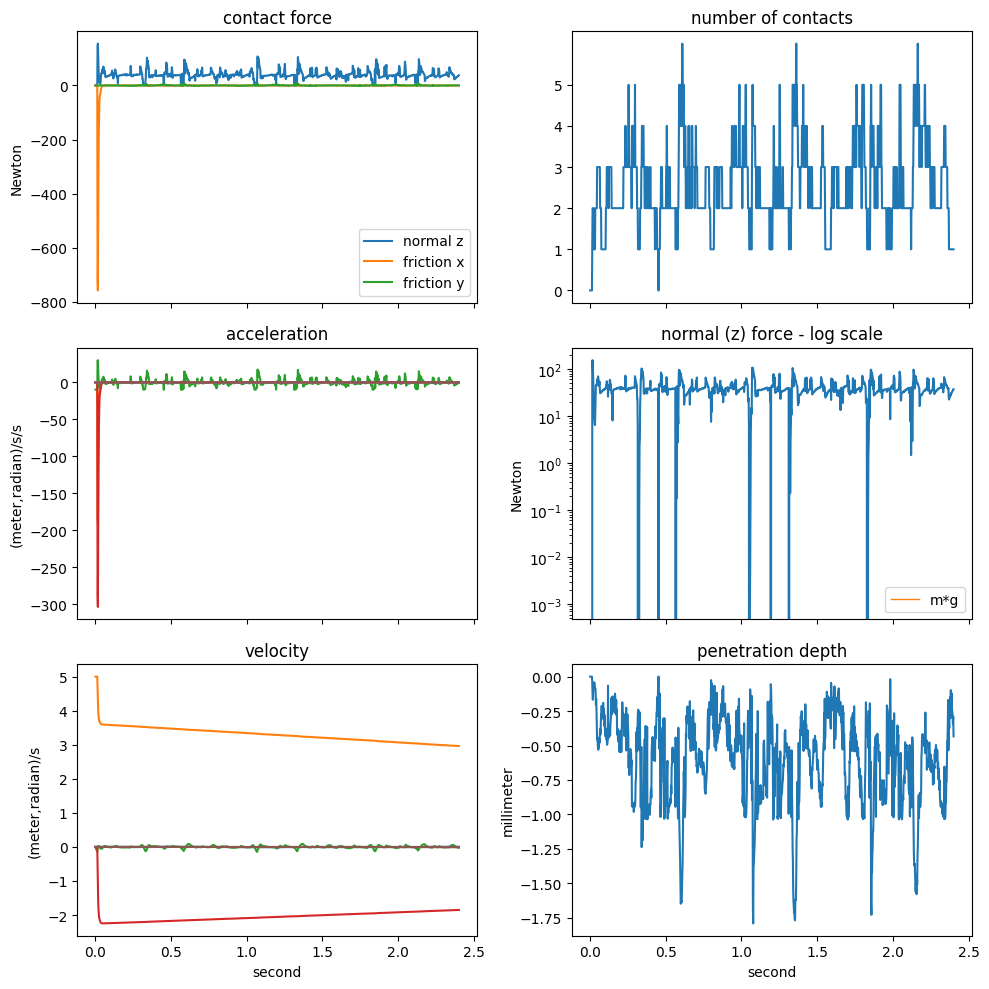

In [10]:
#Full code for dynamics plots
n_steps = 1200

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps) #number of contacts
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)
contacts = []

'''
# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)
'''
mujoco.mj_resetDataKeyframe(model, data, 0) #set frame to frame 0 with init parametrs as defined in xml

# simulate and save data
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  ncon[i] = data.ncon

  #average position of contact forces
  contacts.append(data.contact.pos) #np.mean(data.contact.pos, axis = 0) #data.contact.pos contains [x,y,z] positions for every contact point, here we average the contact points 

  velocity[i] = data.qvel[:]
  acceleration[i] = data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):
    mujoco.mj_contactForce(model, data, j, forcetorque)
    force[i] += forcetorque[0:3]
    penetration[i] = min(penetration[i], c.dist)
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("world").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')


plt.tight_layout()

